# Sparkles - HCIPy Simultions

In [26]:
from hcipy import *
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
# These modules are used for animating some oåf the graphs in our notebook.
from matplotlib import animation, rc
from IPython.display import HTML

from hcipy import atmosphere
from hcipy import fourier

%matplotlib inline

## HCIPY Tutorial

Defining a few parameters according to the MagAO-X specifications:
<br> The Magallen telescope has a diameter of <b>6.5 meters </b>
<br> We will use a sensing wavelength of <b>842nm.</b> 
<br> A zero magnitude star will have flux of <b> 3.9E10 </b> photons/s.

In [2]:
wavelength_wfs = 842.0E-9
telescope_diameter = 6.5
zero_magnitude_flux = 3.9E10
stellar_magnitude = 0

For the pyramid wavefront sensor (and the other Fourier based wavefront sensors), we need to create a <b> grid on which the input wavefront is defined</b> and a grid that defines the output sampling. 
<br> For our case we can use an input grid of 56 pixels across the Magellan pupil. 
<br> The pyramid wavefront sensor of MagAO-X is sampled with 56 pixels across the pupil and has a distance of 60 pixels between the pupils. 
<br> The OCAM2K camera has a total of 120x120 pixels after 2x2 binning. 
<br> For this tutorial we will sample the out wavefront on 120x120 pixels and we will ignore the binning effects.

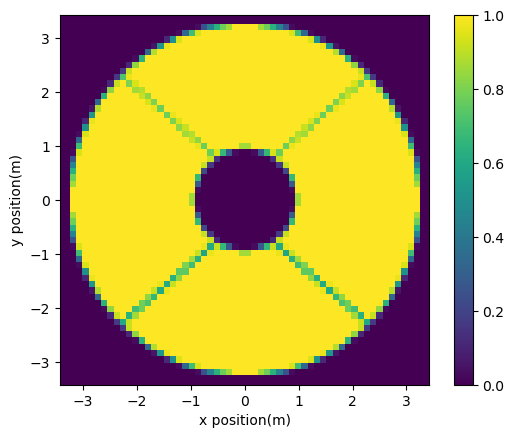

In [3]:
# Creating Magellan Pupil
num_pupil_pixels = 60
pupil_grid_diameter = 60/56 * telescope_diameter
pupil_grid = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)
pwfs_grid = make_pupil_grid(120, 2 * pupil_grid_diameter)
magellan_aperture = evaluate_supersampled(make_magellan_aperture(), pupil_grid, 6)

# Showing pupil grid
imshow_field(magellan_aperture)
plt.xlabel('x position(m)')
plt.ylabel('y position(m)')
plt.colorbar()
plt.show()

# TODO: look into a binary mask, ithout intermediate numbers

Let’s make our deformable mirror. 
<br> MagAO-X uses a <b>2k-MEMS DM</b> of Boston Micromachines. 
<br> The influence functions of the DM are nearly gaussian. => We will therefore make a DM with <b>Gaussian influence functions. </b>
<br> There are <b>50 actuators</b> across the pupil. But for speed purposes we will limit the number of actuators to <b>10 across</b> the pupil.

In [4]:
# Making deformable mirror
num_actuators_across_pupil = 50
actuator_spacing = telescope_diameter / num_actuators_across_pupil
influence_functions = make_gaussian_influence_functions(pupil_grid, num_actuators_across_pupil, actuator_spacing)
deformable_mirror = DeformableMirror(influence_functions)
num_modes = deformable_mirror.num_actuators

Now we are going to make the optics of the pyramid wavefront sensor and the camera. Because the OCAM2K is a very high performance EMCCD we will simulate this detector as a noiseless detector.

In [5]:
pwfs = PyramidWavefrontSensorOptics(pupil_grid, pwfs_grid, separation=pupil_grid_diameter, pupil_diameter=telescope_diameter, wavelength_0=wavelength_wfs, q=3)
camera = NoiselessDetector(pwfs_grid)
modulation = 3
mpwfs = ModulatedPyramidWavefrontSensorOptics(pwfs, modulation)

In [6]:
wf = Wavefront(magellan_aperture, wavelength_wfs)
wf.total_power = 1
#camera.integrate(pwfs.forward(wf), 1) #for a static PWFS
# Eden: modulation needs an averaging function for all steps?
wfs_pywfs = mpwfs.forward(wf)

In [7]:
def mod_forward_int(wfs_pywfs):
    """This iterates on wfs and returns an average of the power
    """
    image_final = 0
    for e, wfs_i in enumerate(wfs_pywfs):
        image_final += wfs_i.power 
    return image_final / ( e + 1) #/num_mod_STEPS

We are going to use a linear reconstruction algorithm for the wavefront estimation and for that we will need to measure the reference response of a perfect incoming wavefront. To create this we create an unabberated wavefront and propagate it through the pyramid wavefront sensor. Then we will integrate the response with our camera.

The final reference will be divided by the total sum to normalize the wavefront sensor response. Doing this consequently for all exposures will make sure that we can use this reference for arbitrary exposure times and photon fluxes.

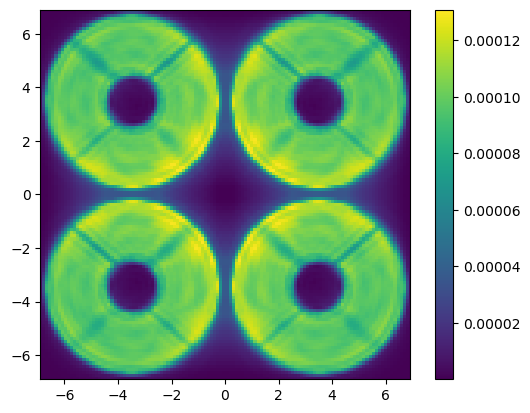

In [8]:
# making a reference image without any aberrations
image_ref = mod_forward_int(wfs_pywfs)
imshow_field(image_ref)
plt.colorbar()
plt.show()

For the linear reconstructor we need to now the interaction matrix, which tells us how the pyramid wavefront sensor responds to each actuator of the deformable mirror. This can be build by sequentially applying a positive and negative voltage on a single actuator. The difference between the two gives us the actuator response.

We will use the full image of the pyramid wavefront sensor for the reconstruction, so we do not compute the normalized differences between the pupils.

In [9]:
# Create the interaction matrix
probe_amp = 0.01 * wavelength_wfs
slopes = []

wf = Wavefront(magellan_aperture, wavelength_wfs)
wf.total_power = 1

for ind in range(num_modes):
    if ind % 10 == 0:
        print("Measure response to mode {:d} / {:d}".format(ind+1, num_modes))
    slope = 0
    deformable_mirror.flatten()
    # Probe the phase response
    for s in [1, -1]:
        #amp = np.zeros((num_modes,))
        #amp[ind] = s * probe_amp
        deformable_mirror.actuators[ind] = s * probe_amp

        dm_wf = deformable_mirror.forward(wf)
        #wfs_wf = pwfs.forward(dm_wf)
        #camera.integrate(wfs_wf, 1)
        #image = camera.read_out()
        #image /= np.sum(image)

        mwfs_wf = mpwfs.forward(dm_wf)
        image = mod_forward_int(mwfs_wf)

        slope += s * (image-image_ref)/(2 * probe_amp)

    slopes.append(slope)

slopes = ModeBasis(slopes)

Measure response to mode 1 / 2500
Measure response to mode 11 / 2500
Measure response to mode 21 / 2500
Measure response to mode 31 / 2500
Measure response to mode 41 / 2500
Measure response to mode 51 / 2500
Measure response to mode 61 / 2500
Measure response to mode 71 / 2500
Measure response to mode 81 / 2500
Measure response to mode 91 / 2500
Measure response to mode 101 / 2500
Measure response to mode 111 / 2500
Measure response to mode 121 / 2500
Measure response to mode 131 / 2500
Measure response to mode 141 / 2500
Measure response to mode 151 / 2500
Measure response to mode 161 / 2500
Measure response to mode 171 / 2500
Measure response to mode 181 / 2500
Measure response to mode 191 / 2500
Measure response to mode 201 / 2500
Measure response to mode 211 / 2500
Measure response to mode 221 / 2500
Measure response to mode 231 / 2500
Measure response to mode 241 / 2500
Measure response to mode 251 / 2500
Measure response to mode 261 / 2500
Measure response to mode 271 / 2500
Mea

KeyboardInterrupt: 

### Restart normal DM work

The matrix that we build by poking the actuators can be used to transform a DM pattern into the wavefront sensor response. For wavefront reconstruction we want to invert this. We currently have,
With
being the response of the wavefront sensor, the interaction matrix and

the incoming pertubation on the DM. This equation can be solved in a linear least squares sense,
The matrix can be found by applying a pseudo-inverse operation on the matrix . A regularized version of this is implemented in HCIpy with the inverse_tikhonov function.

In [52]:
rcond = 1E-3
reconstruction_matrix = inverse_tikhonov(slopes.transformation_matrix, rcond=rcond, svd=None)

Initialize our wavefront and setup the propagator for evaluation of the PSF.

In [53]:
spatial_resolution = wavelength_wfs / telescope_diameter
focal_grid = make_focal_grid(q=8, num_airy=20, spatial_resolution=spatial_resolution)
prop = FraunhoferPropagator(pupil_grid, focal_grid)
norm = prop(wf).power.max()



To have something to measure and correct we put a random shape on the DM.

In [54]:
deformable_mirror.random(0.2 * wavelength_wfs)

Now lets setup the parameters of our AO system. The first step is to choose an integration time for the exposures. We choose an exposure time of 1 ms, so we are running our AO system at 1 kHz. For the controller we choose to use a leaky integrator which has been proven to be a robust controller. The leaky integrator has two parameters, the leakage and the gain.

In [55]:
# Choosing an exposure time!
delta_t = 1E-3
leakage = 0.0
gain = 0.5

Let’s check the current PSF that is created by the deformed mirror.

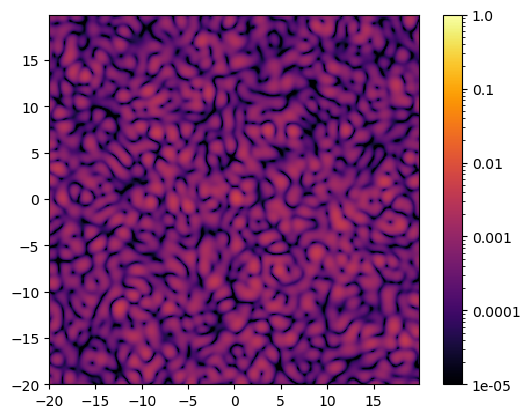

In [56]:
PSF_in = prop(deformable_mirror.forward(wf)).power

imshow_psf(PSF_in / norm, vmax=1, vmin=1e-5, spatial_resolution=spatial_resolution)
plt.show()

### Closed loop system

In [71]:
def create_closed_loop_animation():

    PSF = prop(deformable_mirror(wf)).power

    fig = plt.figure(figsize=(14,3))
    plt.subplot(1,3,1)
    plt.title(r'DM surface shape ($\mathrm{\mu}$m)')
    im1 = imshow_field(deformable_mirror.surface/(1e-6), vmin=-1, vmax=1, cmap='bwr')
    plt.colorbar()

    plt.subplot(1,3,2)
    plt.title('Wavefront sensor output')
    im2 = imshow_field(image_ref, pwfs_grid)
    plt.colorbar()

    plt.subplot(1,3,3)
    plt.title('Science image plane')
    im3 = imshow_field(np.log10(PSF / norm), vmax=0, vmin=-5, cmap='inferno')
    plt.colorbar()

    plt.close(fig)

    def animate(t):
        wf_dm = deformable_mirror.forward(wf)
        wf_pyr = mpwfs.forward(wf_dm)

        wfs_image = mod_forward_int(wf_pyr)

        diff_image = wfs_image - image_ref
        deformable_mirror.actuators = (1-leakage) * deformable_mirror.actuators - gain * reconstruction_matrix.dot(diff_image)

        phase = magellan_aperture * deformable_mirror.surface
        phase -= np.mean(phase[magellan_aperture>0])

        psf = prop(deformable_mirror(wf)).power

        im1.set_data(*pupil_grid.separated_coords, (magellan_aperture * deformable_mirror.surface).shaped / 1e-6)
        im2.set_data(*pwfs_grid.separated_coords, wfs_image.shaped)
        im3.set_data(*focal_grid.separated_coords, np.log10(psf.shaped / norm))

        return [im1, im2, im3]

    num_time_steps=21
    time_steps = np.arange(num_time_steps)
    anim = animation.FuncAnimation(fig, animate, time_steps, interval=160, blit=True)
    return HTML(anim.to_jshtml(default_mode='loop'))

create_closed_loop_animation()


### Fourier Modes basis

Creating a basis of fourier mode

Conclusion: I think that I don't need to make a FT basis for what I'm doing, see sparkel code section where I add in a sparkle simuation on top of other things

In [11]:
# Making a fourier mode DM
fourier_grid = make_pupil_grid(num_actuators_across_pupil, 2*np.pi*num_actuators_across_pupil/telescope_diameter)
fourier_grid = fourier_grid.rotate(0.6)  #number in radians) # rotating? 
fourier_influence_funcs = make_fourier_basis(pupil_grid, fourier_grid)
fourier_deformable_mirror = DeformableMirror(fourier_influence_funcs)

In [12]:
# fourier Modes interaction matrix:
probe_amp = 0.01 * wavelength_wfs
f_slopes = []

wf = Wavefront(magellan_aperture, wavelength_wfs)
wf.total_power = 1

for ind in range(num_modes):
    if ind % 10 == 0:
        print("Measure response to mode {:d} / {:d}".format(ind+1, num_modes))
    f_slope = 0
    fourier_deformable_mirror.flatten()
    # Probe the phase response
    for s in [1, -1]:
        #amp = np.zeros((num_modes,))
        #amp[ind] = s * probe_amp
        fourier_deformable_mirror.actuators[ind] = s * probe_amp

        dm_wf = fourier_deformable_mirror.forward(wf)
        #wfs_wf = pwfs.forward(dm_wf)
        #camera.integrate(wfs_wf, 1)
        #image = camera.read_out()
        #image /= np.sum(image)

        mwfs_wf = mpwfs.forward(dm_wf)
        image = mod_forward_int(mwfs_wf)

        f_slope += s * (image-image_ref)/(2 * probe_amp)

    f_slopes.append(f_slope)

f_slopes = ModeBasis(f_slopes)

Measure response to mode 1 / 2500
Measure response to mode 11 / 2500
Measure response to mode 21 / 2500
Measure response to mode 31 / 2500
Measure response to mode 41 / 2500
Measure response to mode 51 / 2500
Measure response to mode 61 / 2500
Measure response to mode 71 / 2500
Measure response to mode 81 / 2500
Measure response to mode 91 / 2500
Measure response to mode 101 / 2500
Measure response to mode 111 / 2500
Measure response to mode 121 / 2500
Measure response to mode 131 / 2500
Measure response to mode 141 / 2500
Measure response to mode 151 / 2500
Measure response to mode 161 / 2500
Measure response to mode 171 / 2500
Measure response to mode 181 / 2500
Measure response to mode 191 / 2500
Measure response to mode 201 / 2500
Measure response to mode 211 / 2500
Measure response to mode 221 / 2500
Measure response to mode 231 / 2500
Measure response to mode 241 / 2500
Measure response to mode 251 / 2500
Measure response to mode 261 / 2500
Measure response to mode 271 / 2500
Mea

KeyboardInterrupt: 

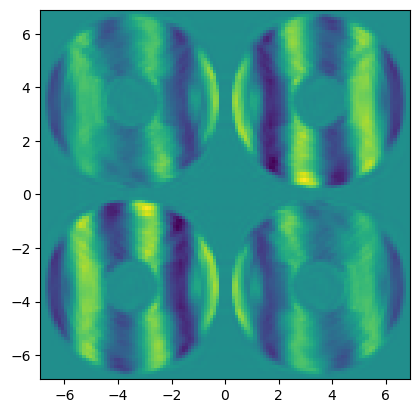

In [47]:
imshow_field(f_slopes.transformation_matrix[:,30], pwfs_grid)

In [49]:
#fourier_deformable_mirror.actuators[25] = 0.15 * wavelength_wfs #this is too strong
fourier_deformable_mirror.actuators[25] = 0.05 * wavelength_wfs

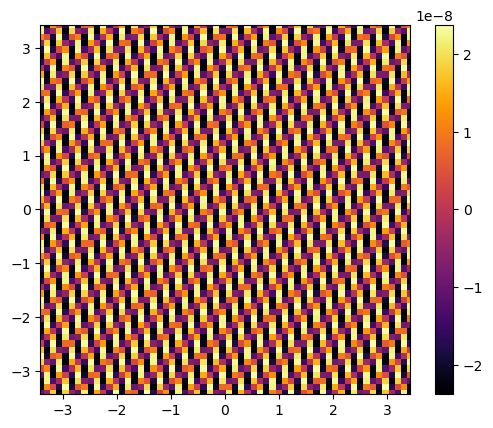

In [48]:
#showing dm command
imshow_field(fourier_deformable_mirror.opd, cmap='inferno')
plt.colorbar()

#as of right now too faint

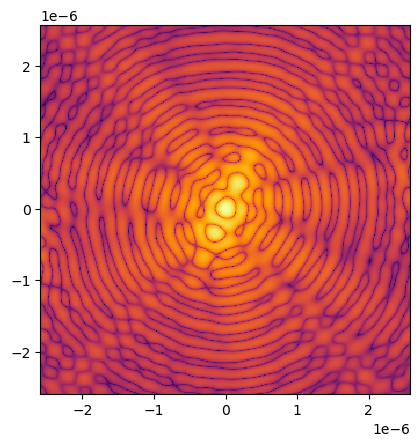

In [50]:
spatial_resolution = wavelength_wfs / telescope_diameter
focal_grid = make_focal_grid(q=8, num_airy=20, spatial_resolution=spatial_resolution)
prop = FraunhoferPropagator(pupil_grid, focal_grid)
psf = prop(fourier_deformable_mirror(wf) ).power
imshow_field(np.log10(psf), cmap='inferno')

### Sparkle Code

In [58]:
#example code:
#act_grid = make_pupil_grid(nact, telescope_diameter)
#pattern_sparkle = 0.1 * np.cos(2 * np.pi * act_grid.x * 15 / telescope_diameter + np.pi)
# testing:
sparks_list = genSpark(num_actuators_across_pupil, telescope_diameter) # check the sim_sparkle code

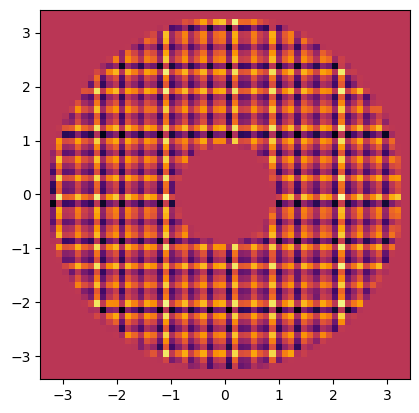

In [20]:
deformable_mirror.actuators = sparks_list[1]
#imshow_field(deformable_mirror.surface, cmap='inferno')
imshow_field(magellan_aperture * deformable_mirror.opd, cmap='inferno')

In [21]:
## Closed loop with sparkles
def create_closed_loop_animation_sparkles():

    PSF = prop(deformable_mirror(wf)).power

    fig = plt.figure(figsize=(14,3))
    plt.subplot(1,3,1)
    plt.title(r'DM surface shape ($\mathrm{\mu}$m)')
    im1 = imshow_field(deformable_mirror.surface/(1e-6), vmin=-1, vmax=1, cmap='bwr')
    plt.colorbar()

    plt.subplot(1,3,2)
    plt.title('Wavefront sensor output')
    im2 = imshow_field(image_ref, pwfs_grid)
    plt.colorbar()

    plt.subplot(1,3,3)
    plt.title('Science image plane')
    im3 = imshow_field(np.log10(PSF / norm), vmax=0, vmin=-5, cmap='inferno')
    plt.colorbar()

    plt.close(fig)

    def animate(t):
        wf_dm = deformable_mirror.forward(wf)
        wf_pyr = mpwfs.forward(wf_dm)

        wfs_image = mod_forward_int(wf_pyr)

        diff_image = wfs_image - image_ref
        deformable_mirror.actuators = (1-leakage) * deformable_mirror.actuators - gain * reconstruction_matrix.dot(diff_image) + sparks_list[t%4] 

        phase = magellan_aperture * deformable_mirror.surface
        phase -= np.mean(phase[magellan_aperture>0])

        psf = prop(deformable_mirror(wf) ).power

        im1.set_data(*pupil_grid.separated_coords, (magellan_aperture * deformable_mirror.surface).shaped / 1e-6)
        im2.set_data(*pwfs_grid.separated_coords, wfs_image.shaped)
        im3.set_data(*focal_grid.separated_coords, np.log10(psf.shaped / norm))

        return [im1, im2, im3]

    num_time_steps=21
    time_steps = np.arange(num_time_steps)
    anim = animation.FuncAnimation(fig, animate, time_steps, interval=160, blit=True)
    return HTML(anim.to_jshtml(default_mode='loop'))

create_closed_loop_animation_sparkles()

NameError: name 'prop' is not defined

## MagAO-X HCIPY functions 
akak testing sim_sparkle.py

In [53]:
import sim_sparkle as smsp
reload(smsp)

<module 'sim_sparkle' from '/home/eden/code/sparkles/sim/sim_sparkle.py'>

In [54]:
# setup MagAO-X system
pupil_grid, pwfs_grid, magellan_aperture = smsp.create_mag_pupil()
deformable_mirror = smsp.create_DM(pupil_grid)
mpwfs, camera = smsp.create_mod_PWFS(pupil_grid, pwfs_grid, n_steps=12)

In [55]:
# wfs
wf = smsp.create_wf(magellan_aperture)
wfs_pywfs = smsp.create_pwfs(mpwfs, wf)
image_ref = smsp.mod_forward_int(wfs_pywfs)

In [5]:
#int mat - this takes a while! (3.5 minutes)
# this code specifically uses a modulated pyramid
slopes = smsp.create_int_mat_mod(deformable_mirror, wf, mpwfs, image_ref)

Measure response to mode 1 / 2500
Measure response to mode 11 / 2500
Measure response to mode 21 / 2500
Measure response to mode 31 / 2500
Measure response to mode 41 / 2500
Measure response to mode 51 / 2500
Measure response to mode 61 / 2500
Measure response to mode 71 / 2500
Measure response to mode 81 / 2500
Measure response to mode 91 / 2500
Measure response to mode 101 / 2500
Measure response to mode 111 / 2500
Measure response to mode 121 / 2500
Measure response to mode 131 / 2500
Measure response to mode 141 / 2500
Measure response to mode 151 / 2500
Measure response to mode 161 / 2500
Measure response to mode 171 / 2500
Measure response to mode 181 / 2500
Measure response to mode 191 / 2500
Measure response to mode 201 / 2500
Measure response to mode 211 / 2500
Measure response to mode 221 / 2500
Measure response to mode 231 / 2500
Measure response to mode 241 / 2500
Measure response to mode 251 / 2500
Measure response to mode 261 / 2500
Measure response to mode 271 / 2500
Mea

## Test sparkles

In [12]:
ret_mat = smsp.create_recon_mat(slopes)
sparks_list = smsp.genSpark(seperation=20, angleOff=0.0, amp = 0.02) # takes in specific params, will iter on this

NameError: name 'slopes' is not defined

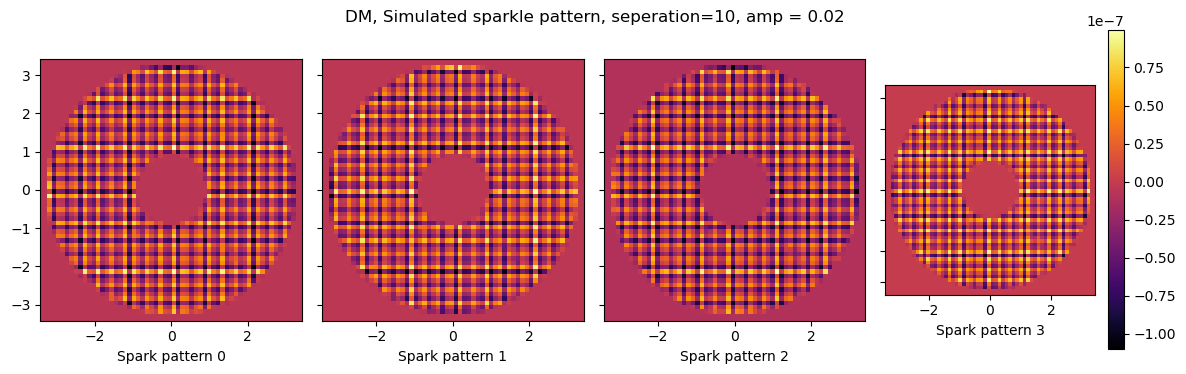

In [8]:
# plotting all the sparkle patterns just to see
# is there an easy way for me to propagate them to the pywfs? showing delay?'

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12,4), facecolor='white', sharey=True)
fig.subplots_adjust(wspace=0)
plt.suptitle(f"DM, Simulated sparkle pattern, seperation=10, amp = 0.02", y=0.90)

for e in range(4):
    plt.sca(axs[e])  
    deformable_mirror.actuators = sparks_list[e]
    imshow_field(magellan_aperture * deformable_mirror.opd, cmap='inferno', label = f'ref {e}', interpolation="nearest")
    plt.xlabel(f"Spark pattern {e}")
plt.colorbar()
plt.tight_layout()
plt.show()


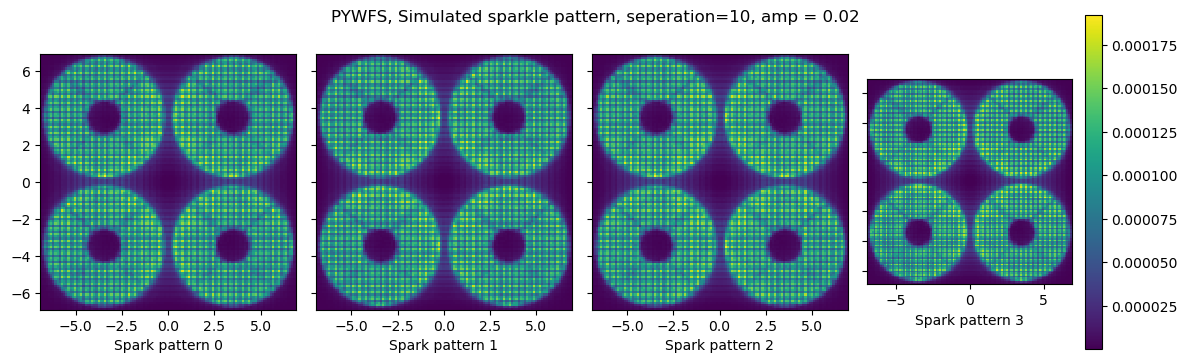

In [9]:
# Plotting the sparkle patterns after propagating to the PYWFS
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12,4), facecolor='white', sharey=True)
fig.subplots_adjust(wspace=0)
plt.suptitle(f"PYWFS, Simulated sparkle pattern, seperation=10, amp = 0.02", y=0.90)

for e in range(4):
    plt.sca(axs[e]) 
    #propagating the specific sparkle pattern 
    deformable_mirror.actuators = sparks_list[e]
    dm_wf = deformable_mirror.forward(wf)
    mwfs_wf = mpwfs.forward(dm_wf)
    wfs_image = smsp.mod_forward_int(mwfs_wf)
    #now showing the pywfs image
    imshow_field(wfs_image, pwfs_grid, cmap='viridis', label = f'ref {e}', interpolation="nearest")
    plt.xlabel(f"Spark pattern {e}")
plt.colorbar()
plt.tight_layout()
plt.show()

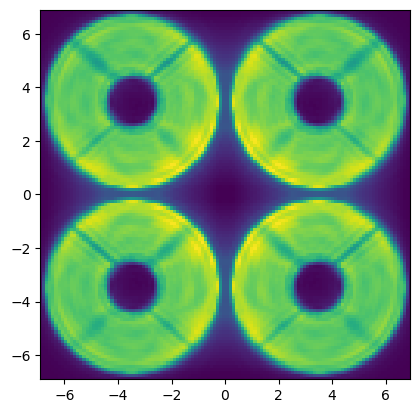

In [10]:
# if we look at the reference image, we see the effects of modulation
imshow_field(image_ref)

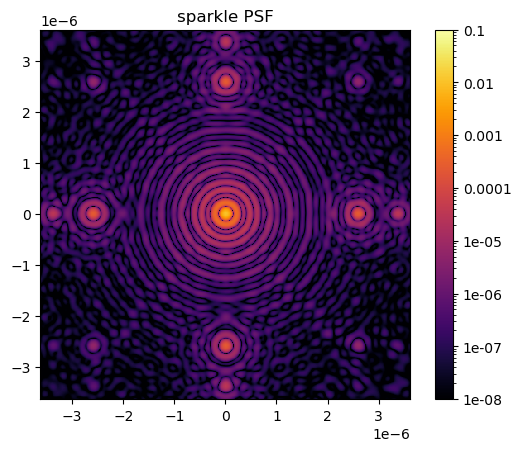

In [11]:
prop, norm = smsp.init_prop(pupil_grid,wf)
psf = prop(deformable_mirror(wf)).power
plt.title("sparkle PSF")
imshow_psf(psf) # TODO: this doesn't look right, might need to 

## Testing: Working with phase screens

In [5]:
# working to make the phase screens to test V Deo's paper
from hcipy import atmosphere
from hcipy import fourier

# This function creates the atmospheric layers expected of LCO
layers = atmosphere.make_las_campanas_atmospheric_layers(pupil_grid)

In [6]:
# creating atmospheric layers
ml_atmsph = atmosphere.MultiLayerAtmosphere(layers)
# using our wavelength to determine phase
phase = ml_atmsph.phase_for(smsp.wavelength_wfs)

In [7]:
# input_grid : the grid expected for the input field
# transfer_function : a circle, to get the high pass filter. 
def high_pass_filter(diameter):
    # using 1 - circle to leave the residual high frequency, just circle is a low pass filter
    def func(grid):
        return 1 - evaluate_supersampled(make_circular_aperture(diameter), grid, 4)
    return func
# set up the high pass filter
ff = fourier.FourierFilter(pupil_grid, high_pass_filter(2 * np.pi * 48 / 6.5))

In [8]:
phase_res = np.real(ff.forward(phase + 0j) )

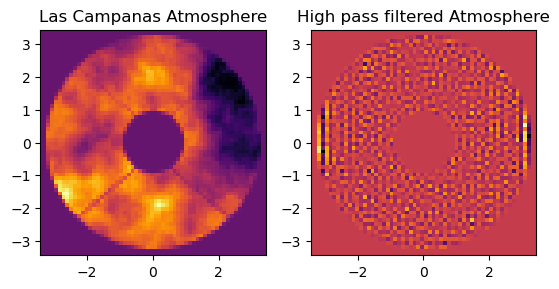

In [9]:
plt.subplot(1,2,1)
plt.title("Las Campanas Atmosphere")
imshow_field(phase * magellan_aperture, cmap='inferno')
plt.subplot(1,2,2)
plt.title("High pass filtered Atmosphere")
imshow_field(phase_res * magellan_aperture, cmap='inferno')
plt.show()

In [10]:
# want to be able to add back in low frequencies
fft = FastFourierTransform(pupil_grid)
PSD = abs(fft.forward(phase))**2
PSD_res = abs(fft.forward(phase_res))**2

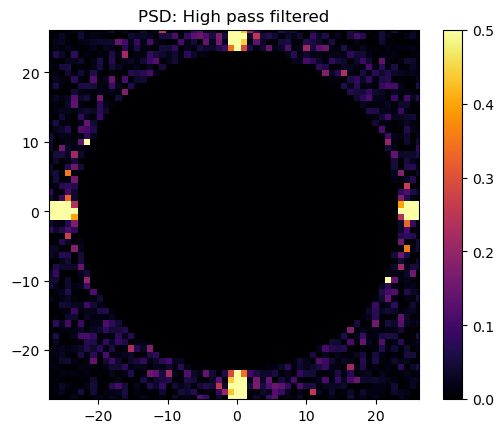

In [11]:
plt.title("PSD: High pass filtered")
imshow_field(PSD_res, vmax =0.5, cmap='inferno')
plt.colorbar()

In [12]:
print("full wavefront:", np.sum(PSD))
print("residual wavefront:", np.sum(PSD_res))

full wavefront: 117533.09857070797
residual wavefront: 152.24939146236116


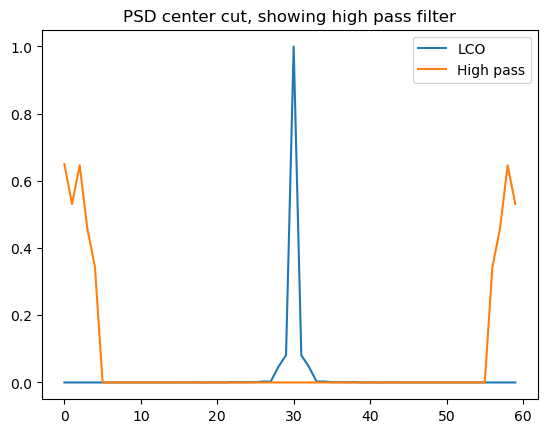

In [13]:
plt.title("PSD center cut, showing high pass filter")
plt.plot(PSD[30::60]/PSD.max(), label="LCO")
plt.plot(PSD_res[30::60]/PSD_res.max(), label="High pass")
plt.legend()

In [14]:
# want to divide by PSF
# create the structure funciton => FT of the residual PSD
# FT of the SD is the covariance function B
# stucture function D = 2 * B(0) - B
# OTF = eponential of - 1/2 * D 
# FT OTF * OTF telescope to get the PSF 
# compare peak with and without aberr to find strehl 

## Creating a zernike DM for adding in modes

In [56]:
# add in zernike modes
# do this by creating azernike DM and propagating through... both DMs?
reload(smsp)
n_z_modes = 100
zern_dm = smsp.create_DM_zern(pupil_grid, n_z_modes, magellan_aperture)

In [57]:
# don't need to do this for residual plot
zern_slopes = smsp.create_int_mat_mod(zern_dm, wf, mpwfs, image_ref) #careful from surface to OPD translation
zern_ret_mat = smsp.create_recon_mat(zern_slopes)

Measure response to mode 1 / 100
Measure response to mode 11 / 100
Measure response to mode 21 / 100
Measure response to mode 31 / 100
Measure response to mode 41 / 100
Measure response to mode 51 / 100
Measure response to mode 61 / 100
Measure response to mode 71 / 100
Measure response to mode 81 / 100
Measure response to mode 91 / 100


#### Making a constant number of atms fields

In [32]:
## Start up for phase stuff
# creating atmospheric layers
ml_atmsph = smsp.LCO_atmosphere(pupil_grid) 
# getting out phase from our multilayer atmosphere
phase = smsp.atms_phase(ml_atmsph)
# filter this phase to make it
phase_res = smsp.filtered_atmosphere(phase, pupil_grid)

# scaling the ODP of 120 nm to phase, scaling the STDV to this
phase_res *= 2*np.pi/smsp.wavelength_wfs * 120e-9 / np.std(phase_res[magellan_aperture>0])

# constructing a new optical element that adds phase tp the system
ao = PhaseApodizer(np.real(phase_res)) 

In [58]:
# make a bunch of phases:
phase_list = []
PSD_list = []
PSD_res_list = []
N_repeats = 10
nm_RMS = 220e-9 # V.Deo uses 120nm

for N in np.arange(N_repeats):
    phase = smsp.atms_phase(ml_atmsph) # this resets the phase
    phase_res = smsp.filtered_atmosphere(phase, pupil_grid) # filter the new phase
    phase_res *= 2*np.pi/smsp.wavelength_wfs * nm_RMS/ np.std(phase_res[magellan_aperture>0])
    phase_list.append(phase_res)
    fft = FastFourierTransform(pupil_grid)
    PSD_list.append(np.sum(abs(fft.forward(phase))**2))
    PSD_res_list.append(np.sum(abs(fft.forward(phase_res))**2))

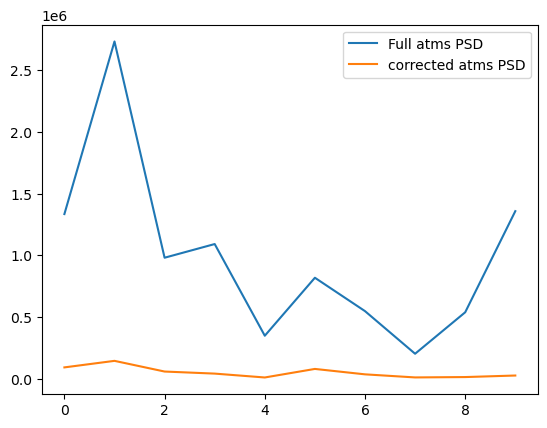

In [59]:
plt.plot(PSD_list, label='Full atms PSD')
plt.plot(PSD_res_list, label="corrected atms PSD")
plt.legend()

#### iteratively making residual plots

In [20]:
# Testing the min/max of the zernike OPD:
test_mode = 0
test_amp = 0.1*smsp.wavelength_wfs

zern_dm.flatten()

# MAKES A NEW ATMOSPERE EACH TIME!
################## OLD BIT ###############
test_phase = smsp.atms_phase(ml_atmsph) # this resets the phase
phase_res = smsp.filtered_atmosphere(test_phase, pupil_grid) # filter the new phase
ao.phase = phase_res
###########################################

# Set up the mode in consideration
zern_dm.actuators[test_mode] = test_amp # rms put in get twice back
wf_zern = zern_dm.forward(wf)
wf_ao = ao(wf_zern)

# propagate through the AO system
wf_pyr = mpwfs.forward(wf_ao)
wfs_image = smsp.mod_forward_int(wf_pyr)

# difference between what we have and what we expect
diff_image = wfs_image - image_ref
coeffs = zern_ret_mat.dot(diff_image) # just use this to reconstruct this amplitude
test_rec = coeffs[test_mode]

In [44]:
# what is our RMS 
np.sqrt(np.mean(np.square(diff_image)))

Field(2.37691786e-05)

In [10]:
# checking zernike P2V
p2v = np.max(zern_dm.opd)+np.abs(np.min(zern_dm.opd))
plt.title(f"mode: {test_mode}, applied amplitude: {test_amp}, \n P2V = {np.round(p2v, decimals=9)}")
imshow_field(zern_dm.opd)
plt.colorbar()
plt.show()

NameError: name 'test_mode' is not defined

In [60]:
# LONG TRIAL
# using the zernike basis, show the saturation of a given mode
# do the atmosphere secnd (generate the curve for each realization of the atmosphere in turn)
wf = smsp.create_wf(magellan_aperture) # fourier filted wf
all_probeamp = np.arange(1e-9, 800e-9, 20e-9)
mode_list = [0, 10 , 90]
mode_recon_amp_res = []
mode_recon_amp_res_quantiles = [] # list of residual results
mode_recon_amp = []

for mode in mode_list:
    recon_amp_res_quantiles = [] # list of residual results
    recon_amp_res = [] # list of residual results
    recon_amp = [] # list of non-residual results
    #running through amplitudes
    for amp in all_probeamp:
        zern_dm.flatten()

        # Non-residual trial
        zern_dm.actuators[mode] = amp/2 # rms put in get twice back
        wf_zern = zern_dm.forward(wf)
        # propagate through the AO system
        wf_pyr = mpwfs.forward(wf_zern)
        wfs_image = smsp.mod_forward_int(wf_pyr)
        # difference between what we have and what we expect
        diff_image = wfs_image - image_ref
        coeffs = zern_ret_mat.dot(diff_image) # just use this to reconstruct this amplitude
        # adding to the 
        recon_amp.append(2*coeffs[mode])

        # Residual trial
        coeffs_trial = []
        for N in np.arange(N_repeats):
            ao.phase = phase_list[N]
            
            # Set up the mode in consideration
            zern_dm.actuators[mode] = amp/2 # rms put in get twice back
            wf_zern = zern_dm.forward(wf)
            wf_ao = ao(wf_zern)
            # propagate through the AO system
            wf_pyr = mpwfs.forward(wf_ao)
            wfs_image = smsp.mod_forward_int(wf_pyr)

            # difference between what we have and what we expect
            diff_image = wfs_image - image_ref
            coeffs = zern_ret_mat.dot(diff_image) # just use this to reconstruct this amplitude
            coeffs_trial.append(2*coeffs[mode])

        # save the reconstructed phase:
        recon_amp_res_quantiles.append(np.quantile(coeffs_trial, q=[.16, .5, .84]))
        recon_amp_res.append(np.average(coeffs_trial))
    #adding to mode specifics
    mode_recon_amp_res.append(recon_amp_res)
    mode_recon_amp_res_quantiles.append(recon_amp_res_quantiles)
    mode_recon_amp.append(recon_amp)

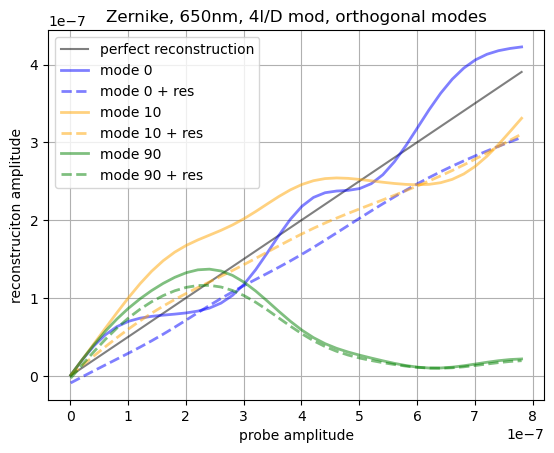

In [64]:
# plotting: the multiple modes:
mode_recon_amp_res = np.array(mode_recon_amp_res)
mode_recon_amp_res_quantiles = np.array(mode_recon_amp_res_quantiles)
mode_recon_amp = np.array(mode_recon_amp)

colors = ['blue', 'orange', 'green']

plt.plot(all_probeamp, all_probeamp/2, alpha=0.5, color = "black", label = "perfect reconstruction")

for e, mode in enumerate(mode_list):
    plt.plot(all_probeamp, mode_recon_amp[e], color = colors[e], lw=2, label = f'mode {mode}', alpha=0.5)
    plt.plot(all_probeamp, mode_recon_amp_res[e], color = colors[e], lw=2, linestyle='dashed', label = f'mode {mode} + res', alpha=0.5)

#plt.ylim([0,4e-7])
plt.xlabel("probe amplitude")
plt.ylabel("reconstruciton amplitude")
plt.title("Zernike, 650nm, 4l/D mod, orthogonal modes")
plt.grid()
plt.legend()

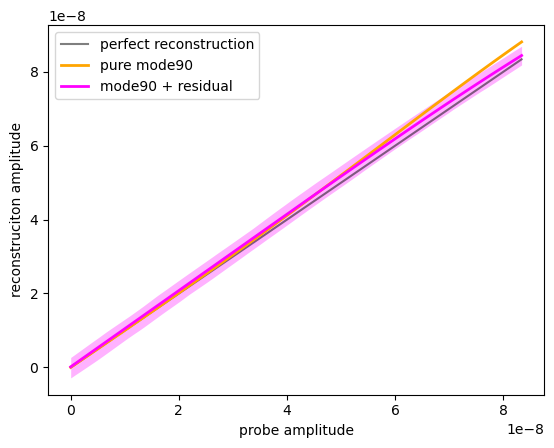

In [84]:
recon_amp_res_quantiles = np.array(recon_amp_res_quantiles)

plt.plot(all_probeamp, all_probeamp, alpha=0.5, color = "black", label = "perfect reconstruction")
plt.plot(all_probeamp, recon_amp, color = 'orange', lw=2, label = 'pure mode90')
plt.fill_between(all_probeamp, recon_amp_res_quantiles[:,0], recon_amp_res_quantiles[:,2], lw=0, color = 'magenta', alpha = 0.3)
plt.plot(all_probeamp, recon_amp_res, color = 'magenta', lw=2, label = 'mode90 + residual')
plt.xlabel("probe amplitude")
plt.ylabel("reconstruciton amplitude")
plt.legend()

## Adding zernike DM 

In [54]:
## gaussian example

# sebastuan says I should just propagate the wavefront through the zernike before going through the DM
wf  =  smsp.create_wf(magellan_aperture) # fourier filted wf
mode = 0
all_probeamp = np.arange(0.00, 0.1, 0.01) * smsp.wavelength_wfs
# we might need to iter on the increasing intensity of the differnt zernike RMS
psf_result = []
deformable_mirror.actuators = deformable_mirror.actuators * 0

for amp in all_probeamp:
    # setting up a new atmospheric residual
    phase = smsp.atms_phase(ml_atmsph) # this resets the phase
    phase_res = smsp.filtered_atmosphere(phase, pupil_grid) # filter the new phase
    ao.phase = phase_res # set the new phase in the atmospheric residual
    zern_dm.actuators[mode] = amp # rms put in get twice back
    # zernike basis is normalized to RMS units

    # Set up phase residuals
    wf_zern = zern_dm.forward(wf)
    wf_ao = ao(wf_zern)

    # propagate through the AO system
    wf_pyr = mpwfs.forward(wf_ao)
    wfs_image = smsp.mod_forward_int(wf_pyr)

    # difference between what we have and what we expect
    diff_image = wfs_image - image_ref
    deformable_mirror.actuators = -ret_mat.dot(diff_image) # just use this to reconstruct this amplitude
    #use the zernike basis to see what exactly we get back wwarsds
    
    # setting the phase
    phase = magellan_aperture * deformable_mirror.surface
    phase -= np.mean(phase[magellan_aperture>0])

    # determining the central core
    psf = prop(deformable_mirror(wf_ao)).power
    psf_result.append(psf)
    

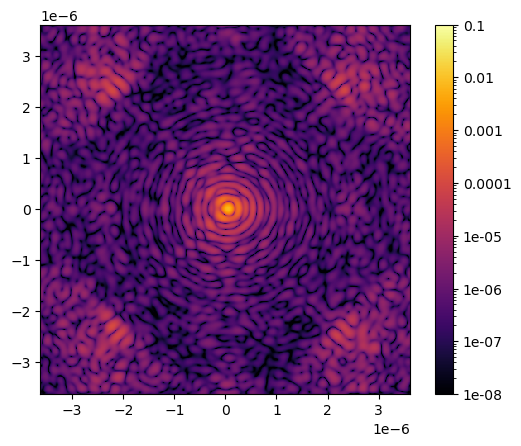

In [59]:
imshow_psf(psf_result[9])